In [1]:
# 기본 라이브러리
!pip install torch torchaudio
!pip install librosa
!pip install yt-dlp
!pip install pydub
!pip install ipython
!pip install matplotlib
!pip install pandas

# FFmpeg 설치 (오디오 변환용)
!apt update > /dev/null 2>&1
!apt install ffmpeg -y > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# 작업 디렉토리 생성
import os
project_dir = '/content/drive/MyDrive/speech_recognition_project'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/data', exist_ok=True)
os.makedirs(f'{project_dir}/recordings', exist_ok=True)
os.makedirs(f'{project_dir}/youtube_audio', exist_ok=True)

Mounted at /content/drive


In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
import IPython
from IPython.display import Audio
import numpy as np
from torchaudio.utils import download_asset

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [4]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr
    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [5]:
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)
print(f"Sample rate: {SAMPLE_RATE}")
print(f"Waveform shape: {SPEECH_WAVEFORM.shape}")

/tmp/ipython-input-774174636.py:1: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
100%|██████████| 106k/106k [00:00<00:00, 5.07MB/s]
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  war

Sample rate: 16000
Waveform shape: torch.Size([1, 54400])


In [18]:
from google.colab import files
import os

# recordings 폴더 생성
recordings_dir = f'{project_dir}/recordings'
os.makedirs(recordings_dir, exist_ok=True)

print("Please upload your recording file (M4A, MP3, WAV 등):")
uploaded = files.upload()

# 업로드된 파일 처리
recording_files = []
for filename, data in uploaded.items():
    # 파일을 recordings 폴더에 저장
    file_path = os.path.join(recordings_dir, filename)

    with open(file_path, 'wb') as f:
        f.write(data)

    print(f"✓ File saved: {file_path}")

    # M4A나 MP3면 WAV로 변환
    if filename.lower().endswith(('.m4a', '.mp3', '.ogg')):
        try:
            from pydub import AudioSegment
            print(f"Converting {filename} to WAV...")

            audio = AudioSegment.from_file(file_path)
            wav_path = file_path.rsplit('.', 1)[0] + '.wav'
            audio.export(wav_path, format='wav')

            print(f"✓ Converted to: {wav_path}")
            recording_files.append(wav_path)

            # 파일 정보 출력
            waveform, sample_rate = torchaudio.load(wav_path)
            duration = waveform.shape[1] / sample_rate
            print(f"  - Duration: {duration:.2f} seconds")
            print(f"  - Sample rate: {sample_rate} Hz")
            print(f"  - Channels: {waveform.shape[0]}")

        except Exception as e:
            print(f"✗ Conversion failed: {e}")

    elif filename.lower().endswith('.wav'):
        print("✓ WAV file ready to use")
        recording_files.append(file_path)

        # 파일 정보 출력
        waveform, sample_rate = torchaudio.load(file_path)
        duration = waveform.shape[1] / sample_rate
        print(f"  - Duration: {duration:.2f} seconds")
        print(f"  - Sample rate: {sample_rate} Hz")
        print(f"  - Channels: {waveform.shape[0]}")

print(f"\n✓ {len(recording_files)} recording files ready for experiment")

Please upload your recording file (M4A, MP3, WAV 등):


Saving 복대동.m4a to 복대동 (1).m4a
✓ File saved: /content/drive/MyDrive/speech_recognition_project/recordings/복대동 (1).m4a
Converting 복대동 (1).m4a to WAV...
✓ Converted to: /content/drive/MyDrive/speech_recognition_project/recordings/복대동 (1).wav
  - Duration: 27.29 seconds
  - Sample rate: 48000 Hz
  - Channels: 1

✓ 1 recording files ready for experiment


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

In [20]:
class AudioFeatureExtractor:
    def __init__(self, sample_rate=16000):
        self.sample_rate = sample_rate

    def extract_spectrogram(self, waveform):
        spectrogram = T.Spectrogram(n_fft=512)
        spec = spectrogram(waveform)
        return spec

    def extract_mel_spectrogram(self, waveform):
        mel_spectrogram = T.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=128,
            norm="slaney",
            mel_scale="htk",
        )
        melspec = mel_spectrogram(waveform)
        return melspec

    def extract_mfcc(self, waveform):
        mfcc_transform = T.MFCC(
            sample_rate=self.sample_rate,
            n_mfcc=40,
            melkwargs={
                "n_fft": 2048,
                "n_mels": 256,
                "hop_length": 512,
                "mel_scale": "htk",
            },
        )
        mfcc = mfcc_transform(waveform)
        return mfcc

    def extract_lfcc(self, waveform):
        lfcc_transform = T.LFCC(
            sample_rate=self.sample_rate,
            n_lfcc=40,
            speckwargs={
                "n_fft": 2048,
                "hop_length": 512,
            },
        )
        lfcc = lfcc_transform(waveform)
        return lfcc

    def extract_pitch(self, waveform):
        pitch = F.detect_pitch_frequency(waveform, self.sample_rate)
        return pitch

In [21]:
# 사전 훈련된 모델 로드
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

# CTC 디코더
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        indices = torch.argmax(emission, dim=-1)
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

decoder = GreedyCTCDecoder(labels=bundle.get_labels())

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


100%|██████████| 360M/360M [00:06<00:00, 61.2MB/s]


Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')



=== WAV2VEC2 ===
Transcript: I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|

=== SPECTROGRAM ===
Transcript: I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


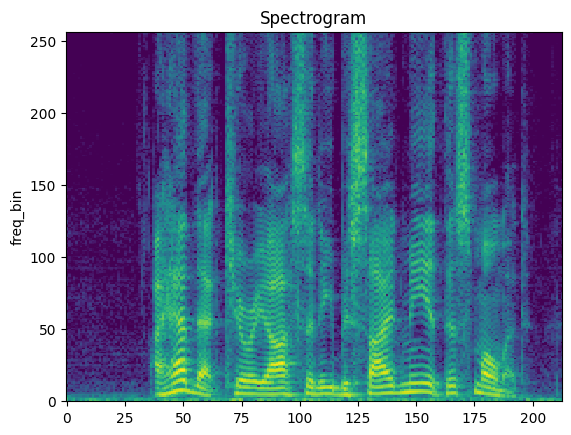


=== MELSPECTROGRAM ===


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Transcript: I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


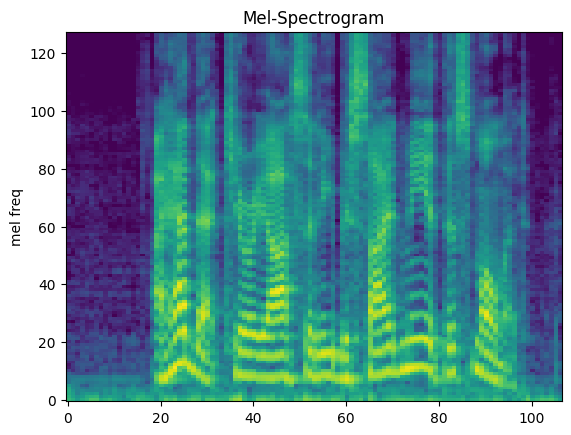


=== MFCC ===
Transcript: I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


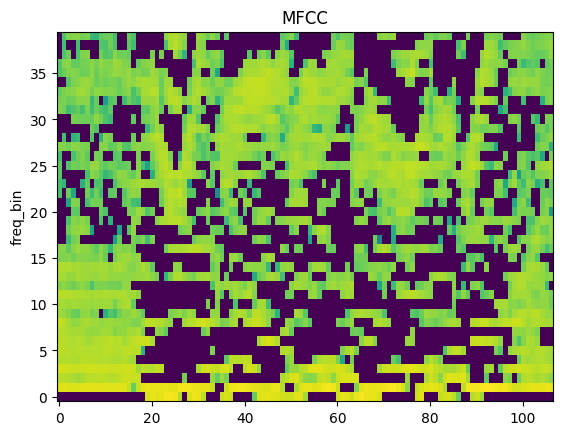


=== LFCC ===
Transcript: I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


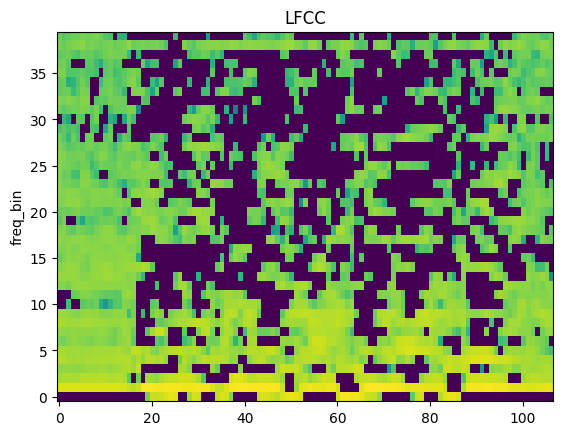

In [22]:
def speech_recognition_pipeline(audio_path, feature_method='wav2vec2'):
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.to(device)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

    # Feature 추출 비교를 위한 다양한 방법
    extractor = AudioFeatureExtractor(bundle.sample_rate)

    if feature_method == 'spectrogram':
        features = extractor.extract_spectrogram(waveform)
        plot_spectrogram(features[0], title="Spectrogram")
    elif feature_method == 'melspectrogram':
        features = extractor.extract_mel_spectrogram(waveform)
        plot_spectrogram(features[0], title="Mel-Spectrogram", ylabel="mel freq")
    elif feature_method == 'mfcc':
        features = extractor.extract_mfcc(waveform)
        plot_spectrogram(features[0], title="MFCC")
    elif feature_method == 'lfcc':
        features = extractor.extract_lfcc(waveform)
        plot_spectrogram(features[0], title="LFCC")

    # 실제 음성 인식 (Wav2Vec2 사용)
    with torch.inference_mode():
        emission, _ = model(waveform)

    transcript = decoder(emission[0])

    return transcript, features if feature_method != 'wav2vec2' else None

# 사용 예시
def test_speech_recognition():
    # 기본 샘플로 테스트
    for method in ['wav2vec2', 'spectrogram', 'melspectrogram', 'mfcc', 'lfcc']:
        print(f"\n=== {method.upper()} ===")
        transcript, features = speech_recognition_pipeline(SAMPLE_SPEECH, method)
        print(f"Transcript: {transcript}")
        plt.show()

test_speech_recognition()

In [23]:
def calculate_wer(reference, hypothesis):
    ref_words = reference.split()
    hyp_words = hypothesis.split()

    d = np.zeros((len(ref_words) + 1) * (len(hyp_words) + 1), dtype=np.uint16)
    d = d.reshape((len(ref_words) + 1, len(hyp_words) + 1))

    for i in range(len(ref_words) + 1):
        for j in range(len(hyp_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            if ref_words[i-1] == hyp_words[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion = d[i][j-1] + 1
                deletion = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(ref_words)][len(hyp_words)] / float(len(ref_words))

 음성 인식 실험을 시작합니다...
✓ Added recording: 복대동.wav
✓ Added recording: 복대동 (1).wav

 Found 3 audio files for testing:
  1. Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav
  2. 복대동.wav
  3. 복대동 (1).wav

 Processing: Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav

--- WAV2VEC2 ---
Transcript: 'I HAD THAT CURIOSITY BESIDE ME AT THIS MOMENT'

--- SPECTROGRAM ---
Transcript: 'I HAD THAT CURIOSITY BESIDE ME AT THIS MOMENT'


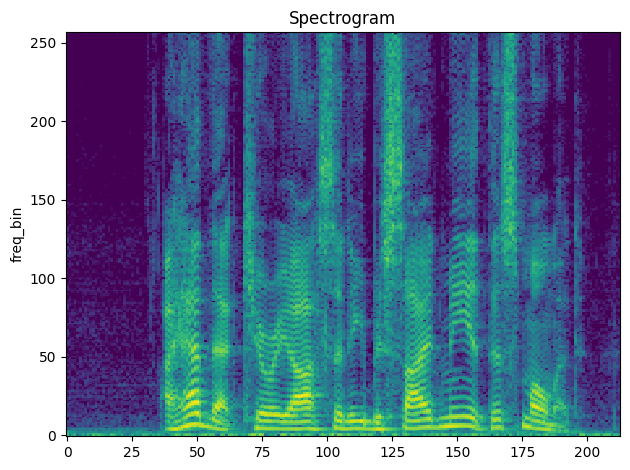


--- MELSPECTROGRAM ---
Transcript: 'I HAD THAT CURIOSITY BESIDE ME AT THIS MOMENT'


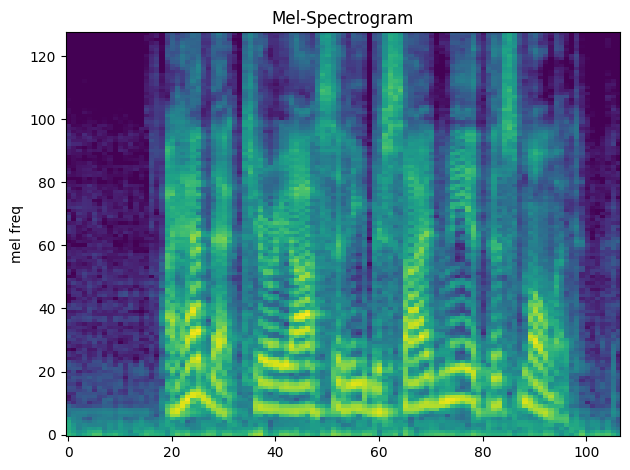


--- MFCC ---
Transcript: 'I HAD THAT CURIOSITY BESIDE ME AT THIS MOMENT'


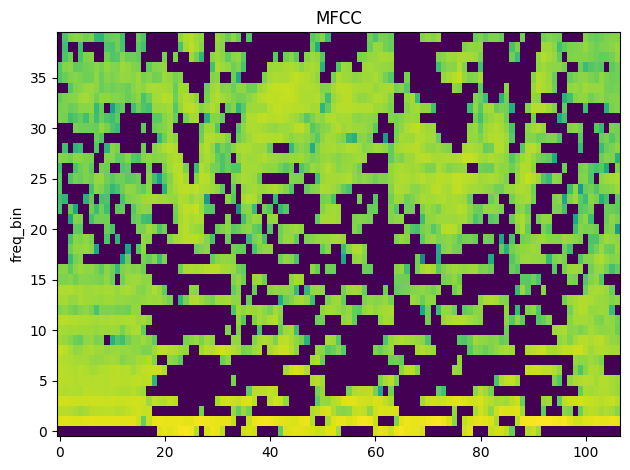


 Processing: 복대동.wav

--- WAV2VEC2 ---
Transcript: 'HE OL  GO ATON MI TAY N EEL SHE CANNOT E NIGHT OW GATAL TINY BONAN NAN O AT AOA GAN MOTER GON HE HANTEWERD THAT TADANAN WITH A VERY UNAN TAN TA A AA A A G A E AA E GOGOA AA FROAATAILEN'

--- SPECTROGRAM ---
Transcript: 'HE OL  GO ATON MI TAY N EEL SHE CANNOT E NIGHT OW GATAL TINY BONAN NAN O AT AOA GAN MOTER GON HE HANTEWERD THAT TADANAN WITH A VERY UNAN TAN TA A AA A A G A E AA E GOGOA AA FROAATAILEN'


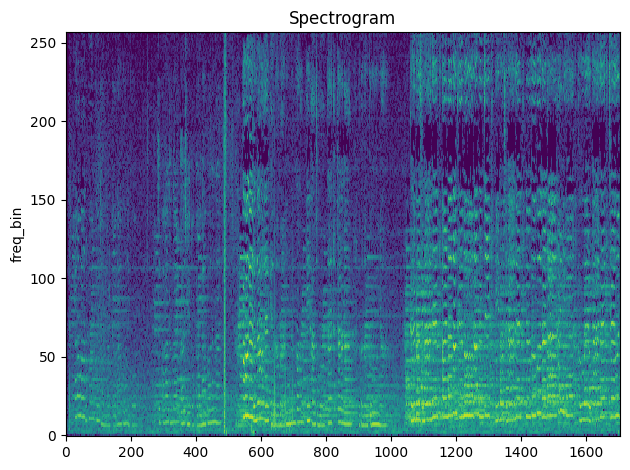


--- MELSPECTROGRAM ---
Transcript: 'HE OL  GO ATON MI TAY N EEL SHE CANNOT E NIGHT OW GATAL TINY BONAN NAN O AT AOA GAN MOTER GON HE HANTEWERD THAT TADANAN WITH A VERY UNAN TAN TA A AA A A G A E AA E GOGOA AA FROAATAILEN'


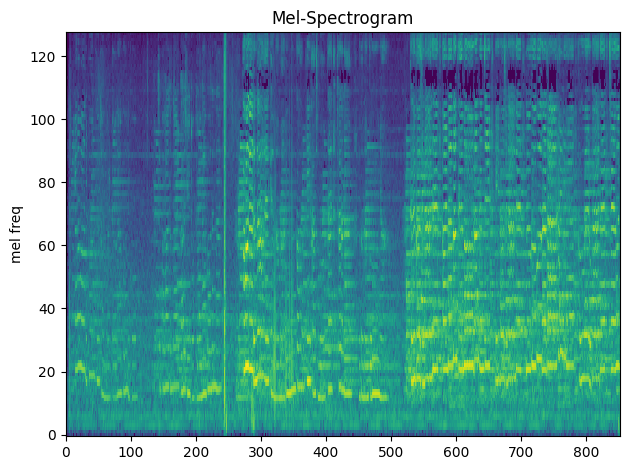


--- MFCC ---
Transcript: 'HE OL  GO ATON MI TAY N EEL SHE CANNOT E NIGHT OW GATAL TINY BONAN NAN O AT AOA GAN MOTER GON HE HANTEWERD THAT TADANAN WITH A VERY UNAN TAN TA A AA A A G A E AA E GOGOA AA FROAATAILEN'


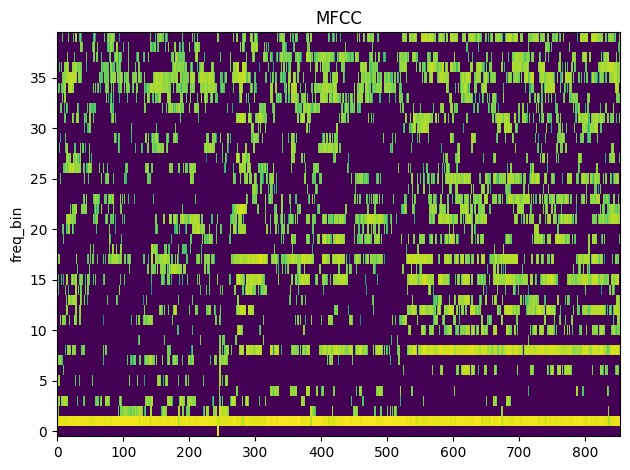


 Processing: 복대동 (1).wav

--- WAV2VEC2 ---
Transcript: 'HE OL  GO ATON MI TAY N EEL SHE CANNOT E NIGHT OW GATAL TINY BONAN NAN O AT AOA GAN MOTER GON HE HANTEWERD THAT TADANAN WITH A VERY UNAN TAN TA A AA A A G A E AA E GOGOA AA FROAATAILEN'

--- SPECTROGRAM ---
Transcript: 'HE OL  GO ATON MI TAY N EEL SHE CANNOT E NIGHT OW GATAL TINY BONAN NAN O AT AOA GAN MOTER GON HE HANTEWERD THAT TADANAN WITH A VERY UNAN TAN TA A AA A A G A E AA E GOGOA AA FROAATAILEN'


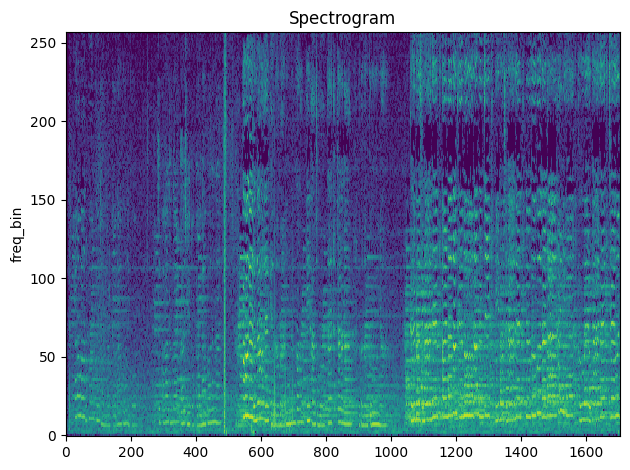


--- MELSPECTROGRAM ---
Transcript: 'HE OL  GO ATON MI TAY N EEL SHE CANNOT E NIGHT OW GATAL TINY BONAN NAN O AT AOA GAN MOTER GON HE HANTEWERD THAT TADANAN WITH A VERY UNAN TAN TA A AA A A G A E AA E GOGOA AA FROAATAILEN'


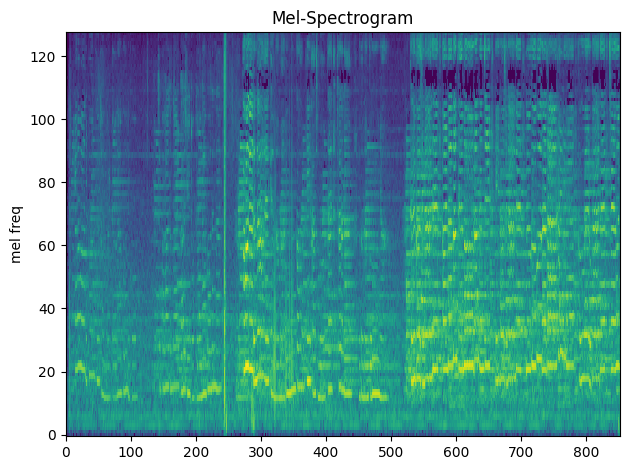


--- MFCC ---
Transcript: 'HE OL  GO ATON MI TAY N EEL SHE CANNOT E NIGHT OW GATAL TINY BONAN NAN O AT AOA GAN MOTER GON HE HANTEWERD THAT TADANAN WITH A VERY UNAN TAN TA A AA A A G A E AA E GOGOA AA FROAATAILEN'


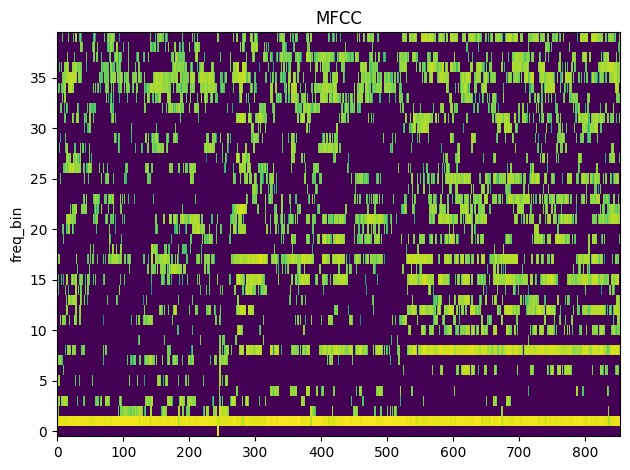


 실험 완료! 총 12개의 결과가 생성되었습니다.


In [27]:
def run_experiments():
    # 데이터 파일 목록
    audio_files = []

    # 1. 기본 샘플 추가
    audio_files.append(SAMPLE_SPEECH)

    # 2. 업로드한 녹음 파일들 추가
    recordings_dir = f'{project_dir}/recordings'
    if os.path.exists(recordings_dir):
        for file in os.listdir(recordings_dir):
            if file.endswith('.wav'):
                file_path = os.path.join(recordings_dir, file)
                audio_files.append(file_path)
                print(f"✓ Added recording: {os.path.basename(file_path)}")

    print(f"\n Found {len(audio_files)} audio files for testing:")
    for i, audio_file in enumerate(audio_files, 1):
        print(f"  {i}. {os.path.basename(audio_file)}")

    # 각 파일에 대해 다양한 feature extraction 방법 테스트
    results = []
    for audio_file in audio_files:
        print(f"\n{'='*50}")
        print(f" Processing: {os.path.basename(audio_file)}")
        print(f"{'='*50}")

        for method in ['wav2vec2', 'spectrogram', 'melspectrogram', 'mfcc']:
            try:
                print(f"\n--- {method.upper()} ---")
                transcript, features = speech_recognition_pipeline(audio_file, method)
                clean_transcript = transcript.replace('|', ' ').strip()
                results.append({
                    'file': os.path.basename(audio_file),
                    'method': method,
                    'transcript': clean_transcript
                })
                print(f"Transcript: '{clean_transcript}'")

                # 파형과 특성 시각화
                if features is not None:
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"✗ Error with {method}: {e}")
                results.append({
                    'file': os.path.basename(audio_file),
                    'method': method,
                    'transcript': f'ERROR: {str(e)}'
                })

    print(f"\n 실험 완료! 총 {len(results)}개의 결과가 생성되었습니다.")
    return results

# 실험 실행
print(" 음성 인식 실험을 시작합니다...")
experiment_results = run_experiments()